# Часовыя шэрагі: імпарт і ачыстка даных

## Load Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
%matplotlib inline

## Define custom functions
### Time series data frame creation function

In [2]:
def time_series(df):
    '''Creates time series data frames with random noise'''
    # simplification of column names
    df_cols = ['reg', 'upd', 'exc'] 
    min_df = min(df[df_cols].min()) 
    max_df = max(df[df_cols].max()) + np.timedelta64(1, 'D')
    # create an empty datetime index
    df_ts = pd.date_range(start=min_df, end=max_df, freq='D', name='date').to_frame(name='ids') 
    for col in df_cols:
        # create a datetime series for each column
        temp_df = df.groupby(col)['num'].count().to_frame(name=col)
        # unite series to a one data frame
        df_ts = df_ts.merge(temp_df, how='left', left_index=True, right_index=True)      
    # delete temporary index
    df_ts.drop(['ids'], axis=1, inplace=True) 
    # NaN could be treated misleading, but in our case zeros make more sense
    df_ts[df_cols] = df_ts[df_cols].fillna(0).astype(int)
    # reshape to monthly data, otherwise it is not enough data for conclusions
    df_ts = df_ts.resample('M').sum() 
    # create random noise for comparison
    mean_rand = (int(np.max(df_ts.std())) + 1) 
    # create random state for reproducibility
    np.random.seed(seed=42) 
    df_ts['rand'] = np.random.randint(0, mean_rand, df_ts.shape[0])
    return df_ts

### Plots creation function

In [3]:
def ts_plot(df, kind):
    '''Creates one of three seaborn multi-plots'''
    # melted data frame is easier to use in seaborn
    melted_df = pd.melt(df, value_vars=['reg', 'upd', 'exc', 'rand'], 
                       var_name='Event', value_name='Number', ignore_index=False)
    melted_df.Event.replace(to_replace={'reg':'Registration', 
                                        'upd':'Update', 
                                        'exc':'Exclusion', 
                                        'rand':'Random Noise'}, inplace=True)
    if kind == 'histogram':
        g = sns.displot(data=melted_df, x='Number', col='Event', 
                        col_wrap=2, hue='Event', kind='hist', 
                        height=3, aspect=2, legend=False)
        g.set_axis_labels('', 'Events Number')
        g.set_titles('{col_name}')
        g.fig.subplots_adjust(top=0.93)
        g.fig.suptitle('Histograms', fontweight='bold')
    elif kind == 'lineplot':
        g = sns.relplot(data=melted_df, x='date', y='Number', 
                        row='Event', hue='Event', kind='line', 
                        height=2, aspect=5, legend=False)
        g.set_axis_labels('', 'Event Numbers')
        g.set_titles('{row_name}')
        g.fig.subplots_adjust(top=0.93)
        g.fig.suptitle('Number of events over time', fontweight='bold')
        for ax in g.axes.flat:
            ax.axhline(y=1, color='gray', linestyle=':')
            # without the next two lines not all years are in xticks
            ax.xaxis.set_major_locator(mdates.YearLocator()) 
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            ax.xaxis.set_tick_params(rotation=45)
    elif kind == 'boxplot':
        g = sns.catplot(data=melted_df, x='Number', y='Event', 
                        kind='box', hue='Event', height=2, 
                        aspect=5.5, legend=False)
        g.set_axis_labels('', '')
        g.fig.subplots_adjust(top=0.93)
        g.fig.suptitle('Boxplots', fontweight='bold')
    else:
        g = 'Nothing to show. Please, specify a histogram, a lineplot, or a boxplot'
    return g  

## Load Data
### Load columns with unique numbers and dates

In [4]:
# simplify column names
cols = ['num', 'reg', 'upd', 'exc'] 

# data related to registration, update, and exclusion of the information systems
sys_df = pd.read_csv('data/inf_sys.csv', parse_dates=[1,2,3], usecols=['numberOnRegistration', 
                                                                       'dateOnRegistration',
                                                                       'dateActyalization',
                                                                       'dateExclude'])
sys_df.columns = cols

# data related to registration, update, and exclusion of the information resources
res_df = pd.read_csv('data/inf_res.csv', parse_dates=[1,2,3], usecols=['numberOnRegistration',
                                                                       'dateOnRegistration',
                                                                       'dateActualization', 
                                                                       'dateExclude'])
res_df.columns = cols

### Make a manageable time series data from raw numbers

In [5]:
# information systems time series data frame
sys_df_dt = time_series(sys_df)

# information resources time series data frame
res_df_dt = time_series(res_df)

## **Inspect information systems events**
---
### The total number of events distributions

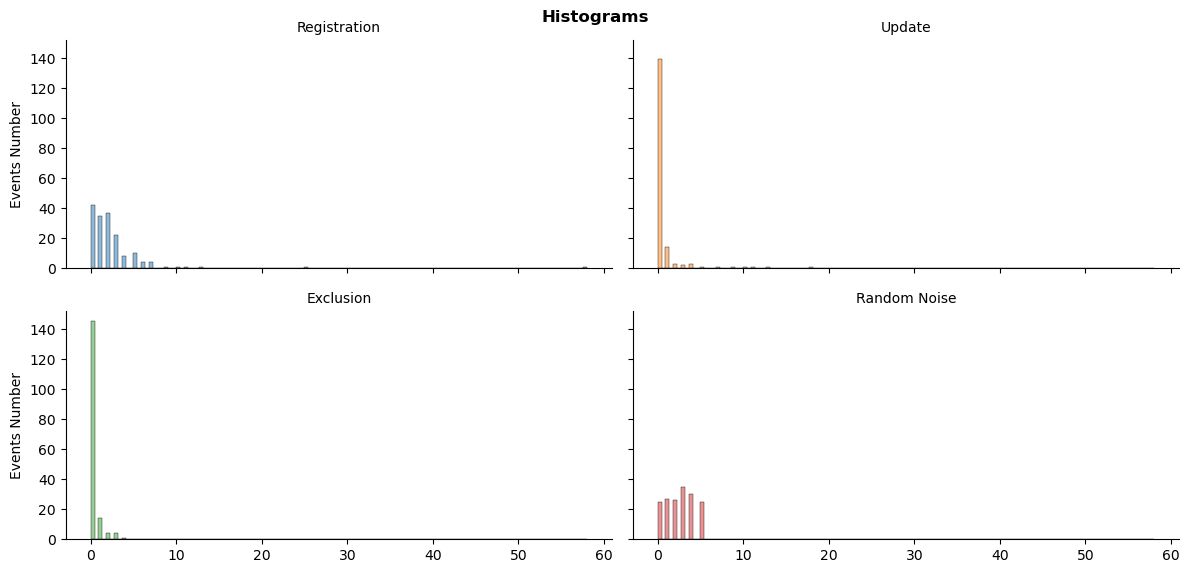

In [6]:
ts_plot(sys_df_dt, 'histogram')
plt.show()

The distributions look highly skewed, especially in comparison to random numbers.

### Boxplot details about total number of events

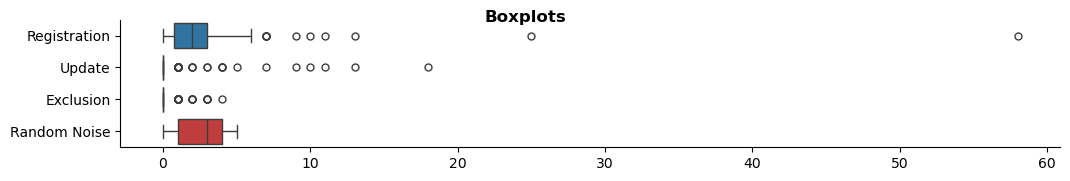

In [7]:
ts_plot(sys_df_dt, 'boxplot')
plt.show()

The number of registrations has more variance, however, the data has enormous outliers.

In [8]:
# Let's have a look at our outliers
sys_df_dt.reg.sort_values(ascending=False)[:3]

date
2014-08-31    58
2014-09-30    25
2014-07-31    13
Name: reg, dtype: int64

The top three outliers are from the second half of 2014.

### Monthly events changes over time

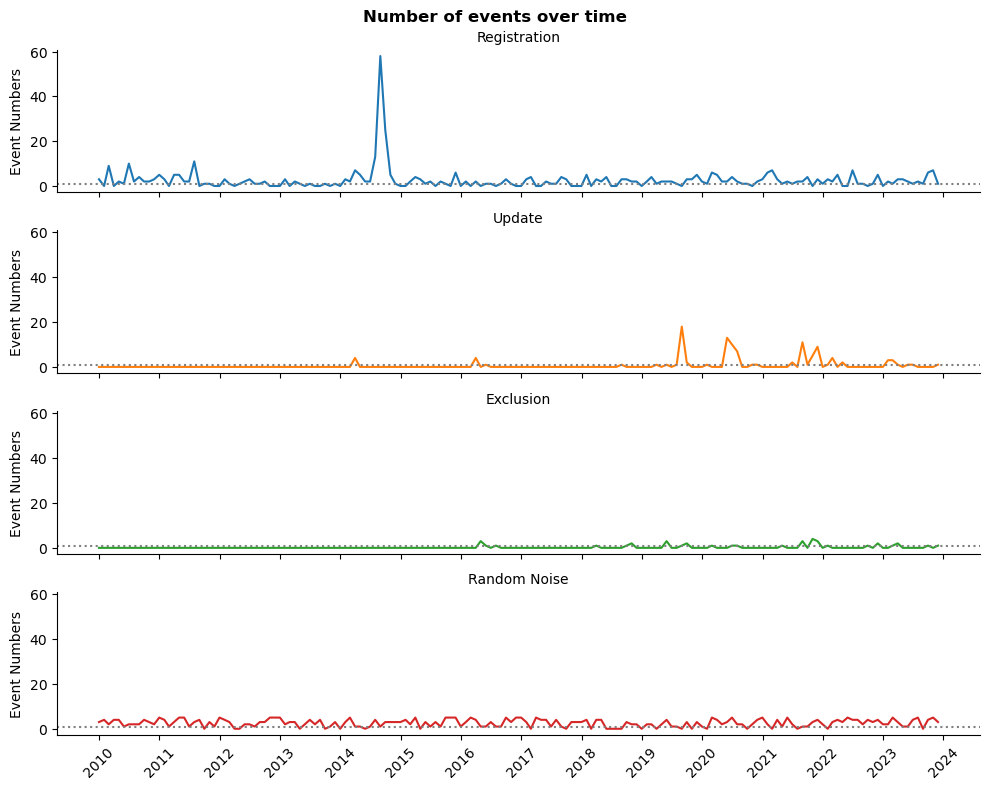

In [9]:
ts_plot(sys_df_dt, 'lineplot')
plt.show()

The gray dotted line represent at least one event per month. As we can see, exclusions from register or record modification are relatively rare events.

We do heave a one unusual peak, which might be necessary to make smoother later. Nevertheless, the plot looks stationary: do not demonstrate any obvious trend or seasonality. 

So, we can build predictive model. However, the most promising is the number of registration per month.

Let's take a look at another data frame.

## **Inspect information resources events**
---
### The total number of events distributions

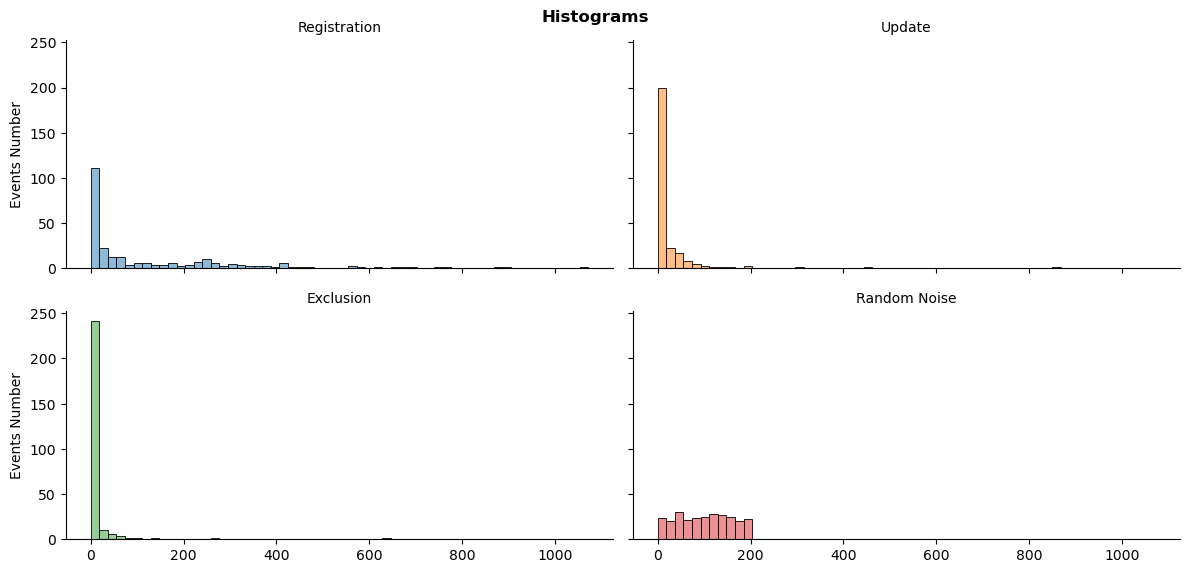

In [10]:
ts_plot(res_df_dt, 'histogram')
plt.show()

The distributions are also skewed. However, the number of registrations is more balanced.

### Boxplot details about total number of events

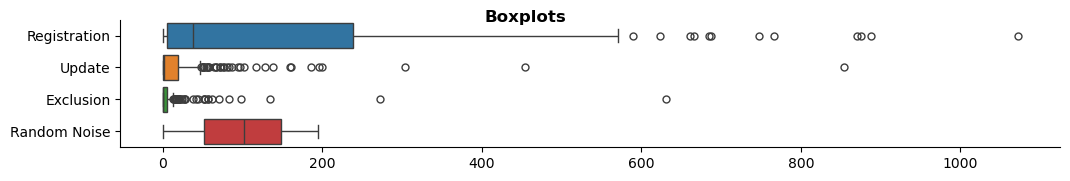

In [11]:
ts_plot(res_df_dt, 'boxplot')
plt.show()

Despite outliers, the variance of the number of registration is closer to random integers.

### Monthly events changes over time

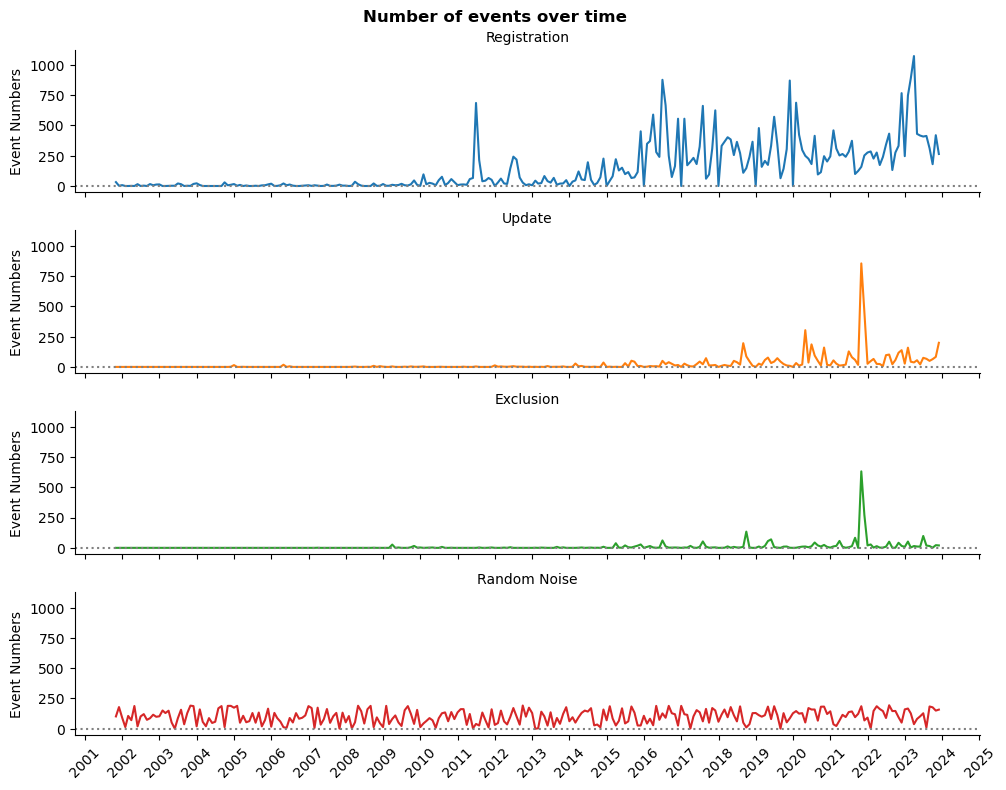

In [12]:
ts_plot(res_df_dt, 'lineplot')
plt.show()

We might have a trend, autocerrelation, and seasonality at the number of registration. The number of record modification became more or less stable since 2018. Other data represents more rare events.

## **Conclusion**
---
We do have enough data for time series analysis of registration information systems and resources. However, it is preferred to treat them separately because they very differ in average monthly numbers and longitude.

Information systems registration does look stationary. Thus, we might need an ARIMA model.

Information resources might have a trend, autocorrelation, and seasonality. That is why we will employ SARIMA model.

Our next step will be modeling this data for explanation and prediction.


In [13]:
# save the modified data for future analysis
os.makedirs('data', exist_ok=True)
sys_df_dt[['reg', 'rand']].to_csv('data/sys_df_dt.csv') 
res_df_dt[['reg', 'rand']].to_csv('data/res_df_dt.csv') 